In [1]:
from tempfile import mkdtemp
import os.path as op
import warnings

import numpy as np

import skimage
from skimage import transform
from skimage.feature import register_translation
from skimage.io import imread_collection, ImageCollection
import skimage.external.tifffile as tiff
import glob as globby


def stitch(image1, image2, margin=100):
    """
    stitches two images together
    
    Parameters
    ----------
    image1 = first image in sequence (2D numpy array)
    image2 = second image in sequence (2D numpy array)
    
    Returns
    -------
    Stitched 2D numpy array
    """
    shift = find_shift(image1, image2)
    registered = apply_shift(image1, image2, shift, margin=margin)
    return registered, shift


def find_shift(image1, image2):
    """ 
    Identify lateral shifts to stitch two images
    
    Parameters
    ----------
    image1, image2 : 2D arrays
        The images to be stitched, *in order* (bottom, top)
    Returns
    -------
    tuple : lateral shifts (x, y)
    """
    
    cols1 = image1.shape[1]
    cols2 = image2.shape[1]
    rows1 = image1.shape[0]
    rows2 = image2.shape[0]
    
    # If we have an odd number of rows, we get uneven indexing. 
    # So we correct, by adding one more row:
    if np.mod(rows2, 2):
        im1_register = image1[:rows2//2+1, int(cols2//2-0.1*cols2):int(cols2//2+0.1*cols2)]
    else:
        im1_register = image1[:rows2//2, int(cols2//2-0.1*cols2):int(cols2//2+0.1*cols2)]

    im2_register = image2[rows2//2:, int(cols2//2-0.1*cols2):int(cols2//2+0.1*cols2)]
    
    shift, error, diffphase = register_translation(im1_register, im2_register)
    return shift


def apply_shift(image1, image2, shift, margin=100):
    """ 
    Apply a lateral shift between two images, stitching them together
    
    Parameters
    ----------
    image1, image2 : 2D arrays
        The images to be stitched, *in order* (bottom, top)
    
    shift : sequence of length 2 
        x, y lateral shifts
    
    Returns
    -------
    Stitched image
    
    """
    cols1 = image1.shape[1]
    cols2 = image2.shape[1]
    rows1 = image1.shape[0]
    rows2 = image2.shape[0]

    overlap = int(rows2 // 2 + shift[0])
    registered = np.zeros((rows1 + rows2 - overlap, cols1), dtype=int)
    registered[:rows2-margin] = image2[:rows2-margin]
    if shift[1] >= 0:
        registered[rows2-margin:, :cols1-int(shift[1])] = image1[overlap-margin:, int(shift[1]):] 
    else:
        registered[rows2-margin:, abs(int(shift[1])):] = image1[overlap-margin:, :int(shift[1])] 
    
    if margin > 0:
        fade2 = image2[rows2 - margin:rows2] * np.arange(1, 0, -(1/margin))[:, np.newaxis]
        fade1 = np.zeros_like(fade2)
        if shift[1] >= 0:
            fade1[:, :cols1-int(shift[1])] = (image1[overlap-margin:overlap, int(shift[1]):] * 
                                              np.arange(0, 1, (1/margin))[:, np.newaxis])
        else:
            fade1[:, abs(int(shift[1])):] = image1[overlap-margin:overlap, :int(shift[1])] * np.arange(0, 1, (1/margin))[:, np.newaxis]

        registered[rows2 - margin:rows2] = fade1 + fade2

    return registered.astype(int)


def test_image(path, first_strip, last_strip, percentile = 50):
    """ 
    Return test image at specified depth within z-stack
    
    Parameters
    ----------
    path : string
        The string of the path 
    first_strip, last_strip : ints
        The index of the first strip and last strip to be stitched, *in order* (bottom, top)
    percentile: int
        Depth of test image within z-stack (larger number is deeper in stack)
    Returns
    -------
    Stitched image (as array) at specified depth
    """
    p = int(np.percentile(np.arange(len(globby.glob1(path,"%06d_*.tif" % first_strip))), percentile))
    image1 = tif.imread(path + '%06d_%06d.tif' % (first_strip, p))
    image2 = tif.imread(path + '%06d_%06d.tif' % (first_strip + 1, p))
    mosaic, shift = stitch(image1, image2) 
    for x in range (first_strip + 2, last_strip): #
        image2 = tif.imread(path + '%06d_%06d.tif' % (x, p))
        mosaic, shift = stitch(mosaic, image2)
    return mosaic


def calc_coef(images_1, images_2, nchan, chan):
    """
    Stitch two z-stacks of tiff strips
    
    Parameters
    ----------
    images_1, images_2 : objects of type ImageCollection, or numpy mem-mapped arrays
    
    nchan : number of channels aquired (int)
    chan : which channel to calculate coefficients (int)
    Returns 
    -------
    Depending on the input: ImageCollection or numpy mem-mapped array
    """
    if nchan > 1:
        images_1 = images_1[chan*images_1.shape[0]//nchan:(chan+1)*images_1.shape[0]//nchan,:]
        images_2 = images_2[chan*images_2.shape[0]//nchan:(chan+1)*images_2.shape[0]//nchan,:]
    
    percentiles = [int(np.percentile(np.arange(len(images_1)), x)) for x in range(30, 80, 10)]
    sub_images_1 = np.zeros((len(percentiles), images_1[0].shape[0], images_1[0].shape[1]))
    sub_images_2 = np.zeros((len(percentiles), images_2[0].shape[0], images_2[0].shape[1]))

    for ii, p in enumerate(percentiles):
        sub_images_1[ii] = images_1[p]
        sub_images_2[ii] = images_2[p]
    
    shift = []
    for x in range(len(sub_images_1)):
        shift.append(find_shift(sub_images_1[x], sub_images_2[x]))
    shift = np.array(shift)
    coef = []
    coef = np.polyfit(percentiles, shift[:,0], 1)
    return coef, shift


def output_zstack(images_1, images_2, coef, shift, chop_index, chan=0, current_stack=None, out_path=None):
    if isinstance(images_1, skimage.io.collection.ImageCollection):
        # Do the relatively slow thing, but save the results
        if out_path is None:
            out_path = '.'
        if current_stack is None:
            current_stack = 1
        for z_level in range(len(images_1)):
            shift_zero = int(np.round(np.polyval(coef, z_level)))
            shift_one = int(np.round(np.mean(shift[:,1])))
            registered = apply_shift(images_1[z_level], images_2[z_level], [shift_zero, shift_one])
            tiff.imsave(op.join(out_path, "mosaic_chan%06d_%06d_%06d.tif"%(chan, current_stack, z_level+1)), 
                        registered[:chop_index]) 
        return ImageCollection(op.join(out_path, "mosaic_chan%06d_%06d_*.tif"%(chan, current_stack)),
                               plugin="tifffile")
    else:
        # Do the relatively fast thing, without saving
        f3 = op.join(mkdtemp(), 'reg.dat')
        h3 = open(f3, 'w')
        registered = np.memmap(f3, dtype=images_1.dtype, shape=(len(images_1), chop_index, images_1[0].shape[1]))
        for z_level in range(len(images_1)):
            shift_zero = int(np.round(np.polyval(coef, z_level)))
            shift_one = int(np.round(np.mean(shift[:,1])))
            registered[z_level] = apply_shift(images_1[z_level], images_2[z_level], 
                                              [shift_zero, shift_one])[:chop_index]

        return registered


def stitch_zstack(images_1, images_2, nchan, chan=0, current_stack=None, out_path=None):
    coef, shift = calc_coef(images_1, images_2, nchan, chan)
    if np.std(shift[:, 0]) > np.sqrt(len(images_1) // nchan): 
        warnings.warn("I am having trouble finding a good registration. Defaulting to no shift")
        shift = np.zeros(shift.shape)
        coef = np.zeros(coef.shape)
    shift_last = int(np.round(np.polyval(coef, len(images_1))))
    rows = images_1[0].shape[0]+images_2[0].shape[0]
    overlap = (images_2[0].shape[0]//2)+shift_last
    chop_index = int(rows - overlap)
    if nchan == 1:
        return output_zstack(images_1, images_2, coef, shift, chop_index, current_stack=current_stack, out_path=out_path)

    if nchan > 1:       
        if isinstance(images_1, skimage.io.collection.ImageCollection):
            im_collection_list = []
            for chan_index in range(nchan):
                im_collection_list.append(output_zstack(
                    images_1[chan_index*images_1.shape[0]//nchan:(chan_index+1)*images_1.shape[0]//nchan,:],
                    images_2[chan_index*images_2.shape[0]//nchan:(chan_index+1)*images_2.shape[0]//nchan,:], 
                    coef, shift, chop_index, current_stack=current_stack, out_path=out_path))
            all_col_files = []
            for col in im_collection_list:
                all_col_files.extend(col.files)
            return imread_collection(all_col_files)    
        else:
            f3 = op.join(mkdtemp(), 'reg_nchan.dat')
            h3 = open(f3, 'w')
            registered = np.memmap(f3, dtype=images_1.dtype, shape=(nchan, len(images_1)//nchan, 
                                                                    chop_index, images_1[0].shape[1]))
            for chan_index in range(nchan):
                registered[chan_index] = output_zstack(
                    images_1[chan_index*images_1.shape[0]//nchan:(chan_index+1)*images_1.shape[0]//nchan,:],
                    images_2[chan_index*images_2.shape[0]//nchan:(chan_index+1)*images_2.shape[0]//nchan,:], 
                    coef, shift, chop_index, current_stack=current_stack, out_path=out_path)
            return registered 

In [2]:
import sys 
sys.path.append('..')
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.external.tifffile as tiff
from skimage import transform
from skimage import img_as_int
import numpy as np
import shutil as sh
import os
from scipy import optimize

In [3]:
from skimage.feature import register_translation
from skimage import img_as_float
from skimage import exposure
from skimage.io import imread_collection, ImageCollection
from skimage.external.tifffile import imread
import skimage.external.tifffile as tif
import skimage
import dask.array as da
from dask import delayed
import glob as globby

In [4]:
import configparser
import os.path as op
from io import BytesIO
import tempfile

In [5]:
file_list = ['/data/%06d_%06d.tif'%(s, i) for s in range(4,9) for i in range(1, 12904) ]

In [6]:
len(file_list)

64515

### Turning frames into z stack

In [7]:
def read_strip_files_desktop(file_list, files_per_strip, ss, dtype, shape):
    """
    From a given list of files read all the tifs in one strip
    and return a memory-mapped array with the data.
    
    Parameters
    ----------
    file_list : list 
        All the file names from one experiment, ordered 
        according to strips 
    
    files_per_strip : int
        How many files (sheets) in each strip.
    
    ss : int
        A strip index.
    
    Return 
    ------
    Memory-mapped array with dimensions (z, width, sheets)
    """
    mm_fd, mm_fname = tempfile.mkstemp(suffix='.memmap')    
    strip_mm = np.memmap(mm_fname, dtype=dtype, 
                         shape=(files_per_strip, shape[0], shape[1]))
    for ii in range(files_per_strip):
        image_file = file_list[ss * files_per_strip + ii]
        strip_mm[ii] = tif.imread(image_file)
    
    mm_roll = np.swapaxes(np.swapaxes(strip_mm, 0, 1), 1, 2)
    # Strips are rastered back and forth, so we flip the odds
    if np.mod(ss, 2):
        return mm_roll[..., ::-1]
    return mm_roll

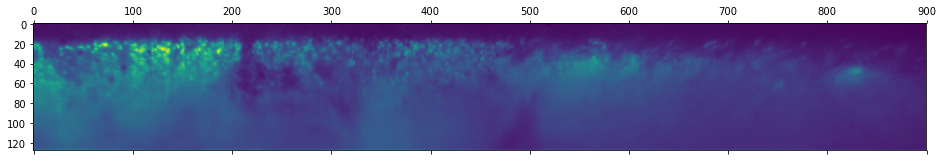

In [48]:
image1 = tif.imread('data/PRO76B_000000_005401.tif')
plt.matshow(image1)

In [10]:
file_list = []
file_list = ['data/PRO76B_%06d_%06d.tif' % (s, i) for s in range(6) for i in range(24000) ]
file_list[143999]

'data/PRO76B_000005_023999.tif'

In [12]:
image1 = tif.imread(file_list[1])
shape = image1.shape
dtype = image1.dtype
shape

(128, 900)

In [15]:
mm_list = []
mm_list = ["mm%01d" % i for i in range(6)]
for i in range(6):
    mm_list[i] = read_strip_files_desktop(file_list, 23999, i, dtype, shape)

In [22]:
import time
t1 = time.time()
mm_list = []
mm_list = ["mm%01d" % i for i in range(6)]
for i in range(6):
    mm_list[i] = read_strip_files_desktop(file_list, 23999, i, dtype, shape)
t2 = time.time()
print(t2-t1)

OSError: [Errno 28] No space left on device

In [26]:
mosaic = stitch_zstack(mm_list[0], mm_list[1], 1, chan=0, current_stack=None, out_path=None)
for i in range(2, 6):
    mosaic = stitch_zstack(mosaic, mm_list[i], 1, chan=0, current_stack=None, out_path=None)
plt.matshow(mosaic[30,:,:])

OSError: [Errno 28] No space left on device

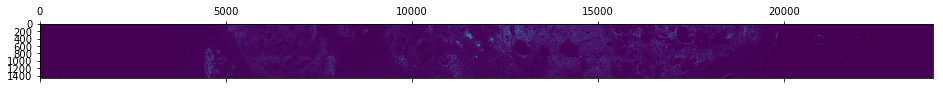

In [130]:
plt.matshow(mosaic[30,:,:])

In [140]:
mosaic = stitch_zstack(mosaic, mm2, 1, chan=0, current_stack=None, out_path=None)

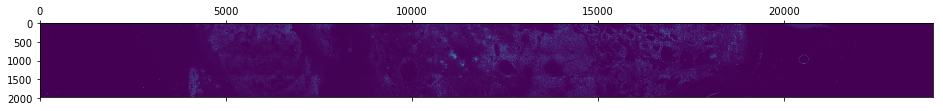

In [141]:
plt.matshow(mosaic[30,:,:])

In [142]:
mm_list = [mm3, mm4, mm5]
for item in mm_list:
    mosaic = stitch_zstack(mosaic, item, 1, chan=0, current_stack=None, out_path=None)

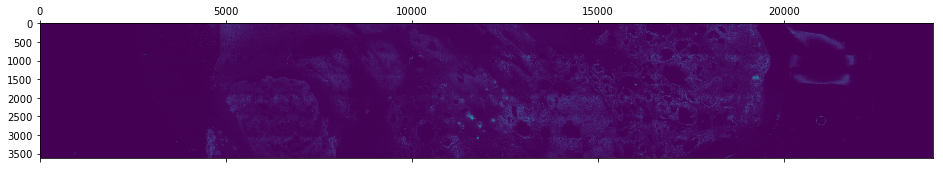

In [143]:
plt.matshow(mosaic[30,:,:])

### Extracting test image

In [12]:
def test_image(path, first_strip, last_strip, percentile = 50):
    p = int(np.percentile(np.arange(len(globby.glob1(path,"%06d_*.tif" % first_strip))), percentile))
    image1 = tif.imread(path + '%06d_%06d.tif' % (first_strip, p))
    image2 = tif.imread(path + '%06d_%06d.tif' % (first_strip + 1, p))
    mosaic, shift = stitch(image1, image2) 
    for x in range (first_strip + 2, last_strip): #
        image2 = tif.imread(path + '%06d_%06d.tif' % (x, p))
        mosaic, shift = stitch(mosaic, image2)
    return mosaic

In [33]:
test_image("data/", 4, 8, percentile=50)

ValueError: could not broadcast input array from shape (15,2026) into shape (143,2026)

In [32]:
s = 4
p = int(np.percentile(np.arange(len(globby.glob1("data/","%06d_*.tif" % 4))), 50))
p

6451

In [31]:
len(globby.glob1("data/","%06d_*.tif" % 4))

12903

In [56]:
import os 
for filename in os.listdir("."):
    scan, strip, frame, junk = re.split("[_.]+", filename)
    strip = int(strip)
    strip = strip - 65537
    strip = str(strip)
    strip = strip.zfill(6)
    frame = int(frame)
    frame = frame - 1
    frame = str(frame)
    frame = frame.zfill(6)
    new_name = scan + "_" + strip + "_" + frame + ".tif"
    os.rename(filename, new_name)

In [60]:
cd ..

C:\Users\LiuLab LSM2\Desktop\melanoma_frames\data
